# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

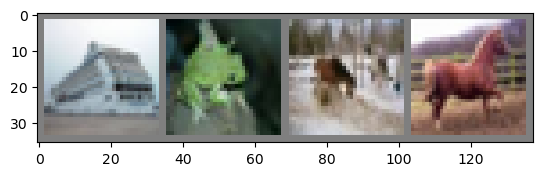

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [6]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32)
        )
        self.block2 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.block3 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8)
        )
        self.block4 = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        out = self.block3(self.block1(x) + self.block2(x))
        out = torch.flatten(out, start_dim=1)
        out = self.block4(out)

        return out

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block3): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (block4): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [47]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        loss = F.cross_entropy(out, target)
        
        loss_log.append(loss.item())
        
        pred = torch.argmax(out, dim=1)
        acc = (pred == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        pred = torch.argmax(out, dim=1)
        acc = (pred == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [48]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4576116666279502, train acc: 0.482004113345521
 val loss: 1.2239478976168532, val acc: 0.5654255319148936

Epoch 1
 train loss: 1.144844663971303, train acc: 0.5993405589237946
 val loss: 1.1153858884851984, val acc: 0.6169326241980208

Epoch 2
 train loss: 1.033898830304852, train acc: 0.6415349960980947
 val loss: 1.074184682775051, val acc: 0.6302969859001485

Epoch 3
 train loss: 0.9847553718896409, train acc: 0.659441107369864
 val loss: 1.061291620325535, val acc: 0.6354609928232559

Epoch 4
 train loss: 0.947435462932482, train acc: 0.6717933859860004
 val loss: 0.9776491489816219, val acc: 0.6610815603682335

Epoch 5
 train loss: 0.9254832132642841, train acc: 0.6772452010968921
 val loss: 0.9617138852464392, val acc: 0.6701462765957447

Epoch 6
 train loss: 0.8976174268251799, train acc: 0.689368960517416
 val loss: 1.058740787303194, val acc: 0.6465203901554676

Epoch 7
 train loss: 0.8821779666587684, train acc: 0.6923805171218607
 val loss: 0.93621270

Посчитайте точность на тестовой выборке:

In [49]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8922296401801383, test acc: 0.6941679936305732


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

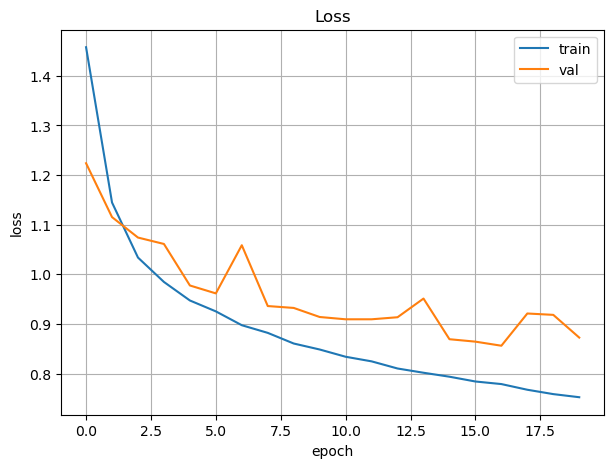

In [50]:
plt.figure(figsize=(7, 5))

plt.plot((np.mean(np.array(train_loss_log).reshape(20, -1), axis=1)), label='train')
plt.plot(val_loss_log, label='val')

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

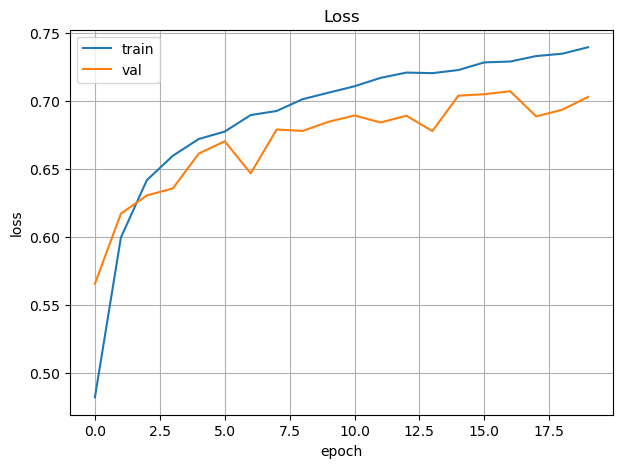

In [51]:
plt.figure(figsize=(7, 5))

plt.plot((np.mean(np.array(train_acc_log).reshape(20, -1), axis=1)), label='train')
plt.plot(val_acc_log, label='val')

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [52]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4737448015640162, train acc: 0.47575248104998574
 val loss: 1.2830958916785868, val acc: 0.5469193263256803

Epoch 1
 train loss: 1.1637742384260272, train acc: 0.5895836053644281
 val loss: 1.1211588560266699, val acc: 0.6084441489361702

Epoch 2
 train loss: 1.0534800331378986, train acc: 0.6322350809299532
 val loss: 1.2129232381252533, val acc: 0.5801640071767442

Epoch 3
 train loss: 0.9898765261473995, train acc: 0.6540790676416819
 val loss: 0.9846501180466185, val acc: 0.6636081561129143

Epoch 4
 train loss: 0.953580466659239, train acc: 0.668945057409555
 val loss: 0.9566727250180346, val acc: 0.6714095744680851

Epoch 5
 train loss: 0.9184979830734037, train acc: 0.6794242948239203
 val loss: 0.9485283526968449, val acc: 0.6730496454746165

Epoch 6
 train loss: 0.8972974270309783, train acc: 0.6877815683101606
 val loss: 0.9178885135244816, val acc: 0.6832003545253835

Epoch 7
 train loss: 0.8818424107605622, train acc: 0.6914337947556044
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [53]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8219241165811089, test acc: 0.7188495222929936


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [54]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8587589159308229, train acc: 0.3467207495429616
 val loss: 1.638520041932451, val acc: 0.4319148936170213

Epoch 1
 train loss: 1.5726133896620225, train acc: 0.44757932882204354
 val loss: 1.488537716358266, val acc: 0.47788120571603165

Epoch 2
 train loss: 1.4449353272561836, train acc: 0.4922956385167905
 val loss: 1.4079154521860975, val acc: 0.5049645389648194

Epoch 3
 train loss: 1.3608522489258315, train acc: 0.5222887829409221
 val loss: 1.3148035287857056, val acc: 0.540203900666947

Epoch 4
 train loss: 1.299637307414625, train acc: 0.5451692674016168
 val loss: 1.2577030752567535, val acc: 0.5647828014607125

Epoch 5
 train loss: 1.2457353484695965, train acc: 0.5635609819640625
 val loss: 1.2152899420007746, val acc: 0.5785682623690748

Epoch 6
 train loss: 1.2046825444458606, train acc: 0.5809570057300588
 val loss: 1.202594034468874, val acc: 0.5804964538584364

Epoch 7
 train loss: 1.1603140465956066, train acc: 0.5963004374198984
 val loss: 1.16

In [55]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.9370919515372841, test acc: 0.6757563694267515


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [57]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4809556059689146, train acc: 0.47113720950086546
 val loss: 1.2341798658066607, val acc: 0.5623005319148936

Epoch 1
 train loss: 1.1387012398221157, train acc: 0.6043598197495915
 val loss: 1.0746367708165594, val acc: 0.6219193263256804

Epoch 2
 train loss: 1.0344742541993122, train acc: 0.6389437516167134
 val loss: 0.9904128384082875, val acc: 0.6546099289934686

Epoch 3
 train loss: 0.9738224891901452, train acc: 0.6635054844606947
 val loss: 1.0275263055841974, val acc: 0.6492907800572983

Epoch 4
 train loss: 0.9401103131731859, train acc: 0.6728666101120944
 val loss: 0.9652566772826174, val acc: 0.6661125885679366

Epoch 5
 train loss: 0.9005183263714178, train acc: 0.6862349830554216
 val loss: 0.9416495718854538, val acc: 0.6750443263256803

Epoch 6
 train loss: 0.8783978461892339, train acc: 0.6942413162705667
 val loss: 0.9185899939942868, val acc: 0.6873891843126175

Epoch 7
 train loss: 0.8544361749340454, train acc: 0.7018599830554216
 val loss: 

In [58]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.848785941388197, test acc: 0.7085987261146497


In [59]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, 20, power=5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.501335785855323, train acc: 0.46311455338485064
 val loss: 1.3085490604664416, val acc: 0.533311170212766

Epoch 1
 train loss: 1.1863258932146774, train acc: 0.5818057913448954
 val loss: 1.130162907154002, val acc: 0.593594858240574

Epoch 2
 train loss: 1.044640880834032, train acc: 0.635262960271818
 val loss: 1.0573441157949732, val acc: 0.6290558510638298

Epoch 3
 train loss: 0.9732689238553509, train acc: 0.661297825834215
 val loss: 1.024155138401275, val acc: 0.6463430851063829

Epoch 4
 train loss: 0.9234475154545451, train acc: 0.6791182424076296
 val loss: 0.9586939689960886, val acc: 0.6755540779296388

Epoch 5
 train loss: 0.8856600867328958, train acc: 0.6957226103576926
 val loss: 0.93962994661737, val acc: 0.6767287234042553

Epoch 6
 train loss: 0.8597455364694543, train acc: 0.7032310982290961
 val loss: 0.9443917147656704, val acc: 0.6748226949509154

Epoch 7
 train loss: 0.8339333612696562, train acc: 0.7127064833693356
 val loss: 0.89283801

In [60]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8552840651979872, test acc: 0.7028264331210191


Метод `ExponentialLR` делает следующее:

$$
    \text{lr} = \text{lr}_0 \cdot \gamma^{\text{epoch}}
$$

Метод `PolynomialLR` делает следующее:

$$
    \text{lr} = \text{lr}_0 \cdot \left( 1 - \frac{\text{epoch}}{\text{max\_epoch}} \right)^{\text{power}}
$$

Однако они не дали лучшего результата, чем `MultiStepLR`.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

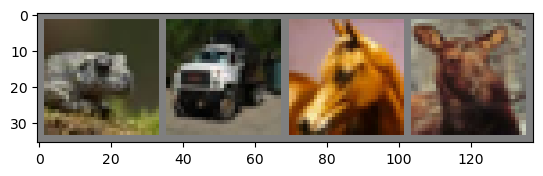

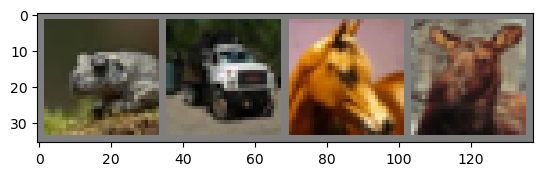

In [61]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [62]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.487519441618562, train acc: 0.4691539892766768
 val loss: 1.2904491333251304, val acc: 0.540735815560564

Epoch 1
 train loss: 1.1908022293878866, train acc: 0.5812875424704125
 val loss: 1.1189249279651237, val acc: 0.6087765957446809

Epoch 2
 train loss: 1.062155974412531, train acc: 0.6287583246745401
 val loss: 1.06074957391049, val acc: 0.6338652481424047

Epoch 3
 train loss: 1.0008763511830319, train acc: 0.6527773243199755
 val loss: 0.9783727039682104, val acc: 0.6657579787234043

Epoch 4
 train loss: 0.9616123380129254, train acc: 0.6652724275423361
 val loss: 1.0153586179652112, val acc: 0.6482934396317664

Epoch 5
 train loss: 0.92410719481857, train acc: 0.6793794071870487
 val loss: 0.9458279434670793, val acc: 0.6687721631628402

Epoch 6
 train loss: 0.910218991461794, train acc: 0.6878427787934186
 val loss: 0.937745171912173, val acc: 0.6705673758019792

Epoch 7
 train l

Посчитайте точность на тестовой выборке:

In [63]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.7955625250840642, test acc: 0.7306926751592356


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [65]:
transform = transforms.Compose(
        [transforms.ColorJitter(0.3, 0.3, 0.1, 0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5573058830100832, train acc: 0.445441042047532
 val loss: 1.3986848075339136, val acc: 0.5021054964116279

Epoch 1
 train loss: 1.246010239316079, train acc: 0.5638221467434815
 val loss: 1.1631235607126926, val acc: 0.5971409574468085

Epoch 2
 train loss: 1.1145189363080361, train acc: 0.6110399255369001
 val loss: 1.1135771634730887, val acc: 0.6152703901554676

Epoch 3
 train loss: 1.0539649432930258, train acc: 0.6342672694753685
 val loss: 1.069182842843076, val acc: 0.6324911348363187

Epoch 4
 train loss: 1.009698831838925, train acc: 0.6512307390652365
 val loss: 1.0582824846531482, val acc: 0.63532801422667

Epoch 5
 train loss: 0.9759141159885762, train acc: 0.6600776965265083
 val loss: 1.0011419991229442, val acc: 0.6533909574468085

Epoch 6
 train loss: 0.9550247101940664, train acc: 0.6690715591693926
 val loss: 1.001518191175258, val acc: 0.6509751773895102

Epoch 7
 train

In [66]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8379156699605809, test acc: 0.7146695859872612


In [70]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=11, sigma=(0.1, 2.0)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6073094545378328, train acc: 0.4273023308957952
 val loss: 1.483128785072489, val acc: 0.4659796099713508

Epoch 1
 train loss: 1.3849971758600126, train acc: 0.5090142661191428
 val loss: 1.3013593470796625, val acc: 0.5403147163543295

Epoch 2
 train loss: 1.2872351620489326, train acc: 0.5452386393080682
 val loss: 1.2414918508935482, val acc: 0.5635638297872341

Epoch 3
 train loss: 1.2217416329619217, train acc: 0.5704287999944669
 val loss: 1.2048328754749704, val acc: 0.5784131206096487

Epoch 4
 train loss: 1.1765336075038317, train acc: 0.5892041003028479
 val loss: 1.1910238544991676, val acc: 0.5879875886947551

Epoch 5
 train loss: 1.1601848856186736, train acc: 0.5915505027422303
 val loss: 1.1769922687652263, val acc: 0.5878324468085107

Epoch 6
 train loss: 1.1344993614627412, train acc: 0.6031356098664962
 val loss: 1.1389466798051875, val acc: 0.6001773050490846

Epoch 7


In [71]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.9822682829419519, test acc: 0.6668988853503185


Метод `ColorJitter` просто напросто меняет яркость, контрастность, насыщенность и оттенок изображения. 

Метод `GaussianBlur` применяет Гауссовское размытие, путём свёртки изображения с двумерным Гауссовским фильтром. 

Улучшить качество не удалось.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
import wandb

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        loss = F.cross_entropy(out, target)
        
        loss_log.append(loss.item())
        
        pred = torch.argmax(out, dim=1)
        acc = (pred == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        pred = torch.argmax(out, dim=1)
        acc = (pred == target).sum() / len(target)
        
        acc_log.append(acc.item()) 
    
    wandb.log({
        'train_loss': np.mean(loss_log),
        'train_acc': np.mean(acc_log)
    })

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        wandb.log({
            'val_loss': val_loss,
            'val_acc': val_acc
        })
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
with wandb.init(project='HW'):
    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                             transform_train=transform)
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)